# Lab 5: PageRank, TrustRank, HITS

### Before you start

- Notebooks tasks can be done individually or in a group of two
- Please save notebooks with outputs filled in - this will speed up the checking process
- Send notebooks with solutions via email:
  - To: michal.wojcik@doctorate.put.poznan.pl
  - Subject format example: [IR] Lab 5 - Jan Kowalski 123456, Anna Nowak 789012
  - Attach: notebook file
- Deadline - 14 days after the class
- Some of the tasks require implementation - complete the code
- Some of the tasks require answering questions - answer them in Markdowns (below the questions)
- The number of points for each task is next to the command

**Team members:**

- Sofya Aksenyuk, 150284;

- Uladzimir Ivashka, 150281.

In [1]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Task 1 - graphs definition [4p]

Prepare some graphs with the networkx library as described. Show:
- list of nodes
- adjacency matrix
- draw a graph

**a) *Random* graph: [1p]**

- 10 nodes
- 25 randomly chosen edges (including edges from node to itself)
- *connected* (looking at the structure if it were an undirected graph; it is not necessary to create a connection between each pair of nodes)
- set a random seed to be reproducible

Nodes:  [8, 7, 5, 9, 2, 3, 6, 1, 4, 0]

Graph Adjacency Matrix:

 [[1 1 1 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 1 1 1]
 [1 1 1 1 1 0 0 0 1 1]
 [0 0 1 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0 0 1]
 [0 0 0 1 1 0 1 0 0 0]
 [0 0 0 1 0 1 0 1 0 1]
 [0 1 0 1 0 0 1 0 1 1]
 [0 1 1 0 0 0 0 1 0 1]
 [0 1 1 0 1 0 1 1 1 0]]


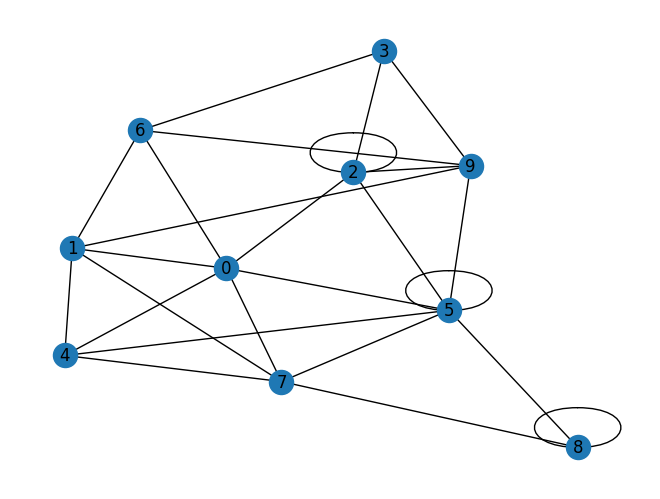

In [2]:
random.seed(123)
nodes = list(range(10))
random.shuffle(nodes)
G_random = nx.path_graph(nodes)

while len(G_random.edges) < 25:
    (x, y) = (random.randint(0, 9), random.randint(0, 9))
    if (x, y) not in G_random.edges:
        G_random.add_edge(x, y)


print("Nodes: ", G_random.nodes)
print(f"\nGraph Adjacency Matrix:\n\n {nx.adjacency_matrix(G_random).todense()}")
nx.draw(G_random, with_labels=True)

**b) *Spider-trap* graph: [1p]**

- at least 5 nodes
- at least 2 nodes in *spider-trap(s)* (2 separate *traps* or 1 *trap* with 2 nodes)

### Note: The provided solution is _general_, since we didn't know if it is allowed to simply specify spider-traps on our own

Successors of each node: {0: {2: {}, 3: {}}, 1: {4: {}, 0: {}}, 2: {}, 3: {3: {}}, 4: {}, 5: {3: {}}}

Nodes:  [0, 1, 2, 3, 4, 5]

Graph Adjacency Matrix:

 [[0 0 1 1 0 0]
 [1 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]]


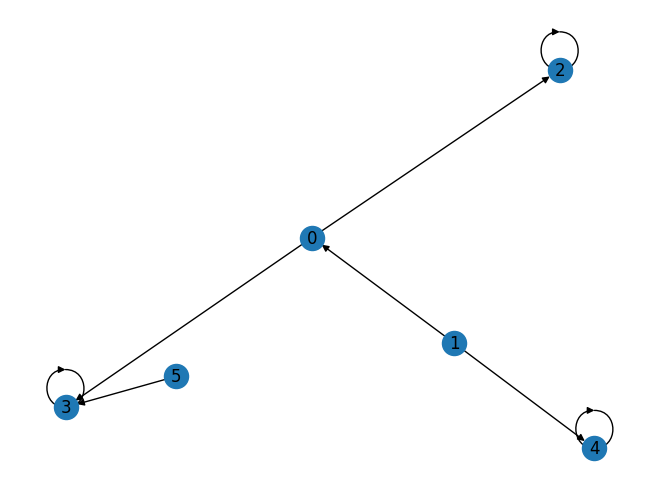

In [3]:
random.seed(1)
G_spidertrap = nx.DiGraph()
init_nodes = [x for x in range(6)]
G_spidertrap.add_nodes_from(init_nodes)
G_spidertrap.add_edges_from([(random.randint(0, 5), random.randint(0, 5)) for x in range(6)])

successors = G_spidertrap.succ
print(f"Successors of each node: {successors}\n")

count = 0
for k, v in successors.items():
    if not len(v):
        G_spidertrap.add_edge(k, k)
        count += 1

while count < 2:
    new_node = random.randint(0, 999)
    if new_node not in init_nodes:
        G_spidertrap.add_node(new_node)
        G_spidertrap.add_edge(new_node, new_node)
        G_spidertrap.add_edge(random.choice(init_nodes), new_node)
        count += 1

print("Nodes: ", G_spidertrap.nodes)
print(f"\nGraph Adjacency Matrix:\n\n {nx.adjacency_matrix(G_spidertrap).todense()}")
nx.draw(G_spidertrap, with_labels=True)

**c) *Death-end* graph: [1p]**

- at least 5 nodes
- 1 or 2 nodes as a *death-end*

Successors of each node: {0: {0: {}, 2: {}}, 1: {5: {}, 4: {}}, 2: {4: {}}, 3: {}, 4: {}, 5: {2: {}}}

Predecessors of each node: {0: {0: {}}, 1: {}, 2: {0: {}, 5: {}}, 3: {}, 4: {2: {}, 1: {}}, 5: {1: {}}}

Nodes:  [0, 1, 2, 3, 4, 5, 36]

Graph Adjacency Matrix:

 [[1 0 1 0 0 0 0]
 [0 0 0 0 1 1 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0]]


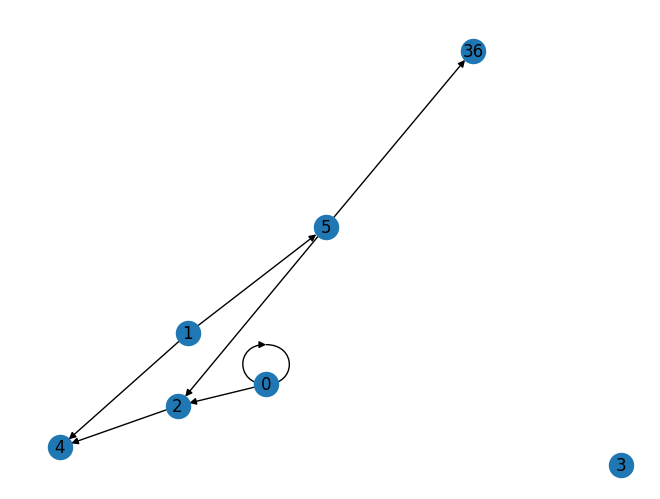

In [4]:
random.seed(2)
G_deathend = nx.DiGraph()
init_nodes = [x for x in range(6)]
G_deathend.add_nodes_from(init_nodes)
G_deathend.add_edges_from([(random.randint(0, 5), random.randint(0, 5)) for x in range(6)])

successors = G_deathend.succ
print(f"Successors of each node: {successors}\n")

predecessors = G_deathend.pred
print(f"Predecessors of each node: {predecessors}\n")

count = 0
for (k, v), (k1, v1) in zip(successors.items(), predecessors.items()):
    if not len(v) and len(v1):
        count += 1
        init_nodes.remove(k)

while count < 2: ## or 1
    new_node = random.randint(0, 999)
    if new_node not in init_nodes:
        G_deathend.add_node(new_node)
        G_deathend.add_edge(random.choice(init_nodes), new_node)
        count += 1      
        
print("Nodes: ", G_deathend.nodes)
print(f"\nGraph Adjacency Matrix:\n\n {nx.adjacency_matrix(G_deathend).todense()}")
nx.draw(G_deathend, with_labels=True)

**d) *Fully-connected* graph: [1p]**

- at least 5 nodes (8 is drawn nicely)
- *every node to every node* connections (except from node to itself)

Nodes:  [0, 1, 2, 3, 4, 5, 6, 7]

Graph Adjacency Matrix:

 [[0 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1]
 [1 1 1 0 1 1 1 1]
 [1 1 1 1 0 1 1 1]
 [1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 0]]


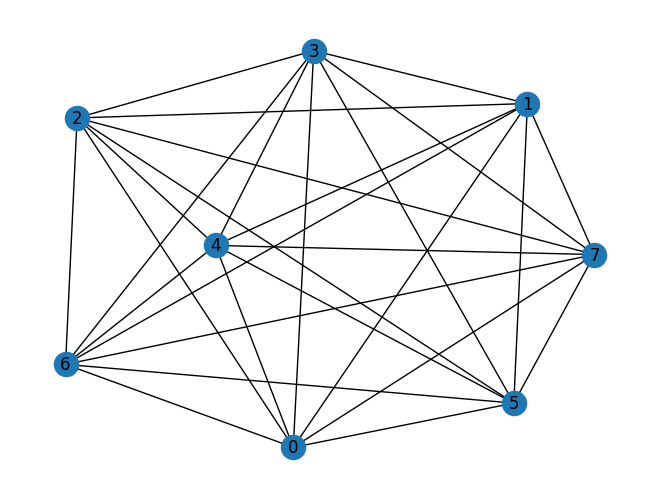

In [5]:
random.seed(2)
G_fullyconnected = nx.complete_graph(8)

print("Nodes: ", G_fullyconnected.nodes)
print(f"\nGraph Adjacency Matrix:\n\n {nx.adjacency_matrix(G_fullyconnected).todense()}")
nx.draw(G_fullyconnected, with_labels=True)

### Task 2 - PageRank algorithm implementation [10p]

Implement two approaches to the PageRank algorithm.

Below is a reference function from the *networkx* package to verify the operation of the implemented functions

In [6]:
def networkx_pagerank(graph: nx.DiGraph, alpha: float = 0.85) -> list:
    # graph - NetworkX Graph
    # alpha - damping parameter (opposite to damping factor from the lecture presentation)
    
    # PageRank by NetworkX library
    pagerank = nx.pagerank(graph, alpha=alpha)

    # Sort dictionary by PageRank value
    pagerank_sorted = sorted(pagerank.items(), key=lambda v:(v[1],v[0]),reverse=True)
    return pagerank_sorted

networkx_pagerank(G_random)

[(5, 0.14145710192916247),
 (0, 0.12278879265913736),
 (9, 0.10648161585236784),
 (7, 0.10542522620026142),
 (2, 0.10534379617103053),
 (1, 0.10529955048801024),
 (6, 0.08815925235999558),
 (4, 0.0853949000696583),
 (8, 0.06990507269894045),
 (3, 0.0697446915714358)]

**a) *Random walk* approach [5p]**

Create a function that will estimate the PageRank value for each node in the graph using the "Random walk" strategy

- Randomly select start node
- In each iteration, go to the next node in the graph (choose one of the neighbors randomly with equal probability)
- If the algorithm reaches a *dead end*, go to a random node
- Count the occurrences of each node on the random walk (normalize at the end)
- Take into account the damping parameter *alpha* ($\alpha$) ($1 - \alpha$ - probability that in a given step the user will start browsing the web from a random page)
- Return the result in the same way as *networkx_pagerank* function - list of tuples sorted in descending order of PageRank value: (node_name, node_pagerank_value)
- Verify the method for different *alpha* values and graphs (random graph, death end, spider trap, clique)

**Note** - for the sake of randomness, this result will be an approximation, but won't be exactly the same as in the *networkx_pagerank* function

In [7]:
def randomwalk_pagerank(graph: nx.DiGraph, alpha: float = 0.85) -> list:
    cur_node = random.choice(list(graph.nodes))
    pagerank = {x: 0 for x in graph.nodes}
    
    for _ in range(100000):
        pagerank[cur_node] += 1
        neighbors = list(graph.neighbors(cur_node))

        if neighbors:
            cur_node = random.choice(neighbors)
        else:
            cur_node = random.choice(list(graph.nodes))
    
        if random.randint(0, 100) < (1 - alpha) * 100:
            cur_node = random.choice(list(graph.nodes))
            
    pagerank = {k: v / sum(pagerank.values()) for k, v in pagerank.items()}
    pagerank_sorted = sorted(pagerank.items(), key=lambda v:(v[1],v[0]),reverse=True)

    return pagerank_sorted
        
randomwalk_pagerank(G_random)

[(5, 0.14099),
 (0, 0.12201),
 (2, 0.10742),
 (9, 0.10629),
 (1, 0.10485),
 (7, 0.10463),
 (6, 0.08896),
 (4, 0.08535),
 (8, 0.07078),
 (3, 0.06872)]

**b) *Stochastic matrix* approach [5p]**

Create a function that will estimate the PageRank value for each of $N$ nodes in the graph using the stochastic adjacency matrix: $v = Mv$.

Using the damping parameter, in order to ensure normalization after each step, the formula changes as follows: $v = (1 - \alpha) \cdot v_{\text{start}} + \alpha \cdot Mv$, where $v_{\text{start}} = [\frac{1}{N}, \frac{1}{N}, \ldots, \frac{1}{N}]$.

- Start with $v = v_{\text{start}}$
- Normalize the adjacency matrix ($M$) so that each cell in the matrix determines the probability of going from $\text{node}_i$ to $\text{node}_j$
- At each iteration, update $v$ with a new vector $v' = Mv$
- Stop the algorithm when the difference between each pair of the PageRank values for the same node in consecutive $v$ and $v'$ vectors is less than the *epsilon* parameter
- Take into account the damping parameter *alpha* ($1 - \alpha$ - probability that in a given step the user will start browsing the web from a random page)
- Return the result in the same way as *networkx_pagerank* function - list of tuples sorted in descending order of PageRank value: (node_name, node_pagerank_value)
- Verify the method for different *alpha* values and graphs (random graph, death end, spider trap, clique)

**Hint** - for the *death ends* it is necessary to modify the values in the matrix to simulate the same behaviour as in the *random walk* approach (go to a random node)

In [8]:
def stochastic_matrix_pagerank(graph: nx.DiGraph, alpha: float = 0.85, epsilon: float = 0.0000001) -> list:
    nodes = sorted(list(graph.nodes))
    v_start = np.repeat(1 / len(nodes), len(nodes))
    M = nx.to_numpy_array(graph, nodelist=nodes)
    
    M /= M.sum(axis=1, keepdims=True)
    M = np.nan_to_num(M)

    v = v_start.copy()
    v_hat = np.repeat(99999, len(v))

    while True:
        '''
        `(1 - alpha) * v_start` doesn't depend on the sum of v => there will always be some fraction. 
        So in case of death ends, sum of v will never reach 0.
        '''
        v = (1 - alpha) * v_start + alpha * (M.T @ v)
        if np.all(abs(v - v_hat) < epsilon):
            break
        v_hat = v.copy()
    
    pagerank = {nodes[i]: v[i] for i in range(len(v))}
    pagerank_sorted = sorted(pagerank.items(), key=lambda v:(v[1],v[0]), reverse=True)

    return pagerank_sorted

stochastic_matrix_pagerank(G_random)

[(5, 0.1414578662579272),
 (0, 0.12278891358394388),
 (9, 0.10648066112507912),
 (7, 0.10542629774594031),
 (2, 0.10534287732365535),
 (1, 0.10529949822839092),
 (6, 0.08815847194305436),
 (4, 0.08539548630149826),
 (8, 0.06990621343345121),
 (3, 0.06974371405705931)]

### Test the functions

GRAPH_NAME: G_random


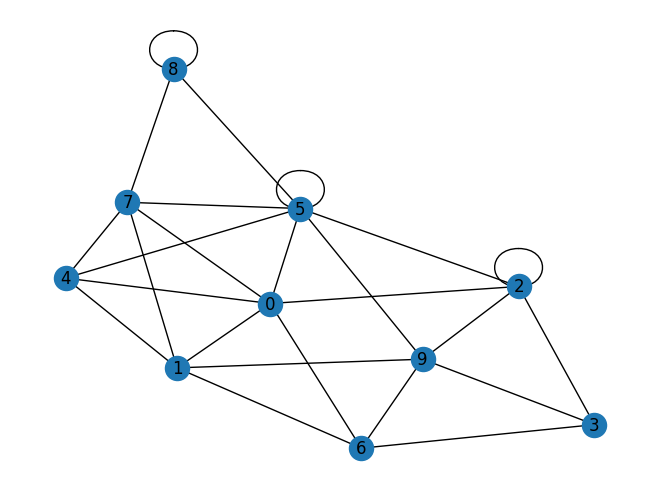

ALPHA: 0.25
(5, 0.11223397346155689)       (5, 0.11228)         (5, 0.11223397207119015)
(0, 0.10617983282847833)       (0, 0.10533)         (0, 0.10617984381104231)
(9, 0.10283545118492235)       (9, 0.10433)         (9, 0.1028354360632408)
(7, 0.1020093334762904)        (2, 0.10245)         (7, 0.10200934016882737)
(1, 0.10159547543194694)       (1, 0.10222)         (1, 0.1015954796639226)
(2, 0.10124332881798956)       (7, 0.10158)         (2, 0.1012433089925989)
(6, 0.09725256895163643)       (6, 0.09558)         (6, 0.09725256012824117)
(4, 0.0936127227231692)        (4, 0.0944)          (4, 0.09361275634165409)
(8, 0.09175506396947694)       (3, 0.09186)         (8, 0.09175507819965988)
(3, 0.09128224915453312)       (8, 0.08997)         (3, 0.09128222455962288)
ALPHA: 0.5
(5, 0.12437262353306153)       (5, 0.12571)         (5, 0.12437298329255668)
(0, 0.11269136101953907)       (0, 0.11162)         (0, 0.11269153235139419)
(9, 0.10497317373044074)       (9, 0.1048)          (9, 

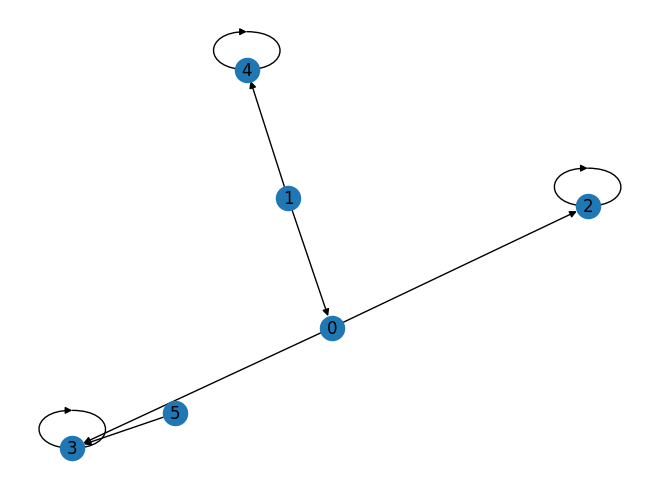

ALPHA: 0.25
(3, 0.23177083333333331)       (3, 0.23384)         (3, 0.23177083333333331)
(2, 0.19010416666666669)       (2, 0.18888)         (2, 0.19010416666666669)
(4, 0.1875)                    (4, 0.18813)         (4, 0.1875)
(0, 0.140625)                  (0, 0.14031)         (0, 0.140625)
(5, 0.125)                     (1, 0.12504)         (5, 0.125)
(1, 0.125)                     (5, 0.1238)          (1, 0.125)
ALPHA: 0.5
(3, 0.3020833333333333)        (3, 0.30379)         (3, 0.3020833333333333)
(2, 0.21875)                   (2, 0.22027)         (2, 0.21875)
(4, 0.20833333333333331)       (4, 0.20791)         (4, 0.20833333333333331)
(0, 0.10416666666666666)       (0, 0.10248)         (0, 0.10416666666666666)
(5, 0.08333333333333333)       (1, 0.08296)         (5, 0.08333333333333333)
(1, 0.08333333333333333)       (5, 0.08259)         (1, 0.08333333333333333)
ALPHA: 0.7
(3, 0.36208333333333326)       (3, 0.3603)          (3, 0.36208333333333326)
(2, 0.24541666666666667)      

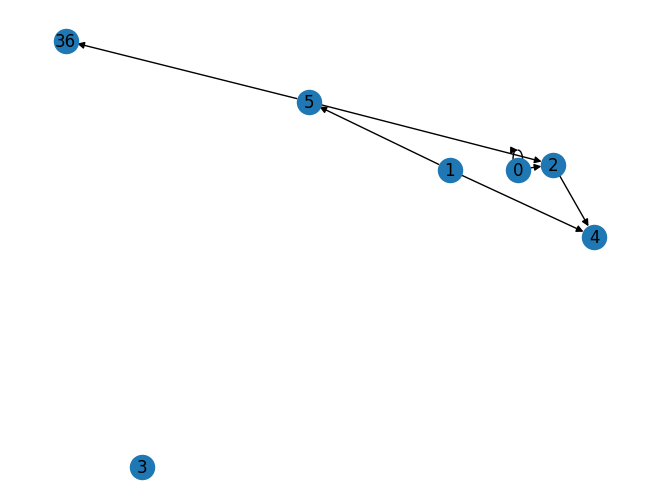

ALPHA: 0.25
(4, 0.17767265384552566)       (4, 0.17754)         (4, 0.1549147026879447)
(2, 0.15771788782137883)       (2, 0.15726)         (2, 0.13751594509397233)
(0, 0.1404374869586132)        (0, 0.14161)         (0, 0.12244898080825806)
(36, 0.14016320847754002)      (36, 0.13939)        (36, 0.12220982142857142)
(5, 0.13824314766739348)       (5, 0.13802)         (5, 0.12053571428571427)
(3, 0.12288280761477438)       (3, 0.12318)         (3, 0.10714285714285714)
(1, 0.12288280761477438)       (1, 0.123)           (1, 0.10714285714285714)
ALPHA: 0.5
(4, 0.21560123662331182)       (4, 0.21775)         (4, 0.1480654988970075)
(2, 0.17118051191058906)       (2, 0.17145)         (2, 0.11755953516278947)
(0, 0.13867816198633268)       (0, 0.13868)         (0, 0.09523810659136091)
(36, 0.1365112450732254)       (36, 0.13573)        (36, 0.09375)
(5, 0.1300110541086029)        (5, 0.12911)         (5, 0.08928571428571427)
(3, 0.10400889514896902)       (3, 0.10366)         (3, 0.0714285

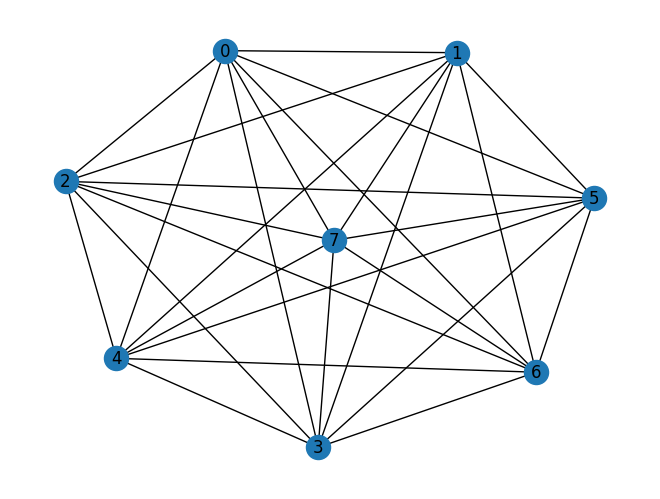

ALPHA: 0.25
(7, 0.125)                     (3, 0.12666)         (7, 0.125)
(6, 0.125)                     (6, 0.12588)         (6, 0.125)
(5, 0.125)                     (4, 0.12582)         (5, 0.125)
(4, 0.125)                     (2, 0.12495)         (4, 0.125)
(3, 0.125)                     (0, 0.12443)         (3, 0.125)
(2, 0.125)                     (7, 0.12437)         (2, 0.125)
(1, 0.125)                     (1, 0.12405)         (1, 0.125)
(0, 0.125)                     (5, 0.12384)         (0, 0.125)
ALPHA: 0.5
(7, 0.12499999999999999)       (3, 0.12679)         (7, 0.125)
(6, 0.12499999999999999)       (5, 0.12619)         (6, 0.125)
(5, 0.12499999999999999)       (1, 0.12555)         (5, 0.125)
(4, 0.12499999999999999)       (7, 0.12539)         (4, 0.125)
(3, 0.12499999999999999)       (2, 0.12456)         (3, 0.125)
(2, 0.12499999999999999)       (0, 0.12427)         (2, 0.125)
(1, 0.12499999999999999)       (4, 0.12379)         (1, 0.125)
(0, 0.12499999999999999)       (

In [9]:
names = ['G_random', 'G_spidertrap', 'G_deathend', 'G_fullyconnected']
graphs = [G_random, G_spidertrap, G_deathend, G_fullyconnected]

for name, graph in zip(names, graphs):
    print("==================")
    print("GRAPH_NAME:", name)
    nx.draw(graph, with_labels=True)
    plt.show()
    
    for alpha in [0.25, 0.5, 0.7, 0.85, 1.0]:
        print('ALPHA:', alpha)
        nx_res = networkx_pagerank(graph, alpha)
        rw_res = randomwalk_pagerank(graph, alpha)
        sm_res = stochastic_matrix_pagerank(graph, alpha)
        for nx_node, rw_node, sm_node in zip(nx_res, rw_res, sm_res):
            print(f"{str(nx_node):{30}} {str(rw_node):{20}} {sm_node}")

# Catan fandom Wikipedia

The scripts used for scraping are in the *scraper.ipynb* file.

Pages come from Fandom Wikipedia: https://catan.fandom.com/wiki/Main_Page

In [10]:
with open('catan_links.pickle', 'rb') as handle:
    d = pickle.load(handle)

G_catan = nx.DiGraph(d)

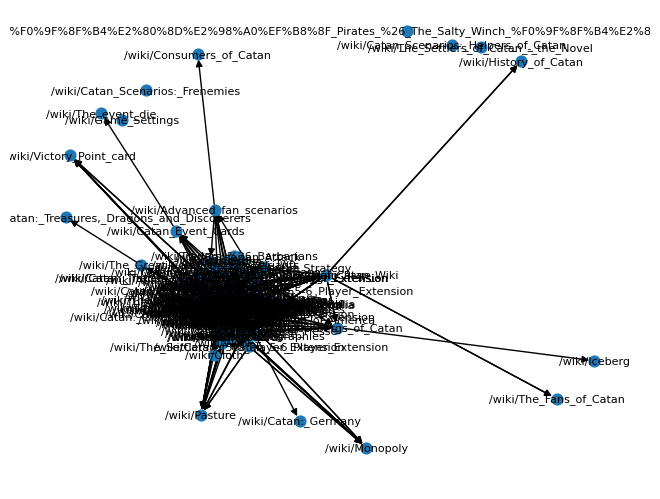

In [11]:
nx.draw(G_catan, with_labels=True, node_size=60, font_size=8)

In [12]:
networkx_pagerank(G_catan)

[('/wiki/The_Settlers_of_Catan', 0.09532314219412437),
 ('/wiki/Catan:_Seafarers', 0.03349508715460648),
 ('/wiki/Catan:_Traders_%26_Barbarians', 0.03172935659245708),
 ('/wiki/City', 0.028254309909030387),
 ('/wiki/Scenario', 0.027629072895623535),
 ('/wiki/Catan:_Cities_%26_Knights', 0.025537852533458884),
 ('/wiki/Mayfair_Games', 0.025172959397811705),
 ('/wiki/Settlement', 0.024073918573428183),
 ('/wiki/Kosmos', 0.023411212689086826),
 ('/wiki/Klaus_Teuber', 0.022253005140779884),
 ('/wiki/Resource_card', 0.022187820545084905),
 ('/wiki/Catan', 0.021618848127220012),
 ('/wiki/The_Settlers_of_Catan_5-6_Player_Extension', 0.017028602460957998),
 ('/wiki/Fishermen_of_Catan', 0.014629434349042052),
 ('/wiki/Catan:_Explorers_%26_Pirates', 0.012914584660461132),
 ('/wiki/Brick', 0.01244668075788728),
 ('/wiki/Lumber', 0.012381957990526396),
 ('/wiki/Development_card', 0.012272904956320042),
 ('/wiki/Out_of_the_Box', 0.011480202090563354),
 ('/wiki/Traders_%26_Barbarians', 0.011319237583

### Review subgraphs

('/wiki/The_Settlers_of_Catan', 0.16341649050253454)
('/wiki/City', 0.11359731125157921)
('/wiki/Road', 0.059185167132182345)
('/wiki/Resource_hex', 0.056299843140026964)
('/wiki/Catan', 0.047463454031323585)
('/wiki/Brick', 0.04283496737472926)
('/wiki/Lumber', 0.04196514046830725)
('/wiki/Forest', 0.036902910875925427)
('/wiki/Development_card', 0.03566398068462476)
('/wiki/Hill', 0.0336158122329555)
('/wiki/Mountain', 0.030816823052154354)
('/wiki/Field', 0.030816823052154354)
('/wiki/Ore', 0.029663770725438122)
('/wiki/Grain', 0.029663770725438122)
('/wiki/Ship', 0.02879580458508869)
('/wiki/Pasture', 0.028442817411593907)
('/wiki/Knight_card', 0.02445038781558948)
('/wiki/Wool', 0.02311518385869055)
('/wiki/Desert', 0.023114616819339313)
('/wiki/Longest_Road', 0.019682097651882516)
('/wiki/Hex', 0.014803150966327472)
('/wiki/Paper', 0.012366006163784797)
('/wiki/Gold_Field', 0.01147847798616387)
('/wiki/Harbor_settlement', 0.009344680212459268)
('/wiki/Harbor', 0.00812694072224409

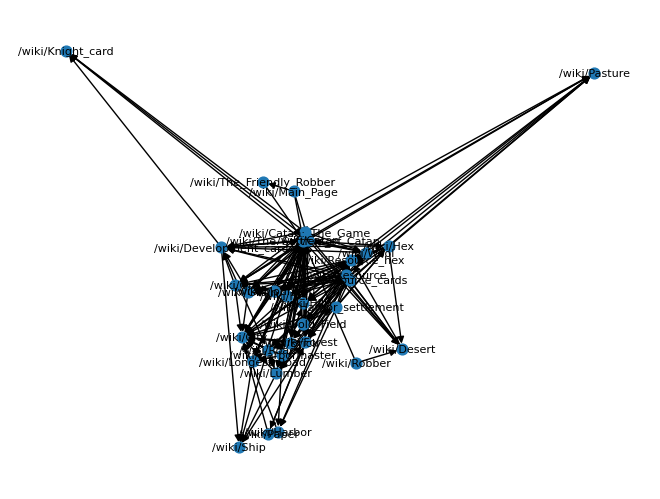

In [13]:
interesting_pages = [
    '/wiki/City', '/wiki/Knight_card', '/wiki/Robber', '/wiki/Desert', '/wiki/Harbor', '/wiki/Pasture',
    '/wiki/Paper', '/wiki/Ship', '/wiki/The_Friendly_Robber', '/wiki/Longest_Road', '/wiki/Brick', 
    '/wiki/Grain', '/wiki/Ore', '/wiki/Field', '/wiki/Hill', '/wiki/Lumber', '/wiki/Wool', 
    '/wiki/Harbor_settlement', '/wiki/Road', '/wiki/Forest', '/wiki/Gold_Field', '/wiki/Mountain', 
    '/wiki/Harbormaster', '/wiki/Hex', '/wiki/Main_Page', '/wiki/Resource', '/wiki/Resource_cards', 
    '/wiki/Development_card', '/wiki/Resource_hex', '/wiki/Catan', '/wiki/Catan:_The_Game', '/wiki/The_Settlers_of_Catan'
]

G_sub_catan = G_catan.subgraph(interesting_pages)

for t in networkx_pagerank(G_sub_catan):
    print(t)
    
nx.draw(G_sub_catan, with_labels=True, node_size=60, font_size=8) 

### Task 3 - Analysis of the subset of pages about building costs [4p]

<img src="catan_building_costs.jpg" alt="drawing" width="500"/>

,/wiki/Settlement,/wiki/Grain,/wiki/Development_card,/wiki/Ore,/wiki/Brick,/wiki/Lumber,/wiki/Road,/wiki/Wool,/wiki/City
/wiki/Settlement,0,1,0,1,1,1,0,1,1
/wiki/Grain,1,0,1,0,0,0,0,0,1
/wiki/Development_card,0,0,0,0,0,0,1,0,0
/wiki/Ore,1,0,1,0,0,0,0,0,1
/wiki/Brick,1,0,0,0,0,0,1,0,1
/wiki/Lumber,1,0,0,0,0,0,1,0,1
/wiki/Road,1,0,0,0,1,1,0,0,1
/wiki/Wool,1,0,1,0,0,0,0,0,1
/wiki/City,0,0,0,0,0,0,0,0,0


('/wiki/City', 0.20085746141355568)
('/wiki/Settlement', 0.1759333697951493)
('/wiki/Road', 0.16371476308045152)
('/wiki/Lumber', 0.0953497433194973)
('/wiki/Brick', 0.0953497433194973)
('/wiki/Development_card', 0.08711274778232866)
('/wiki/Wool', 0.06056072376317328)
('/wiki/Ore', 0.06056072376317328)
('/wiki/Grain', 0.06056072376317328)


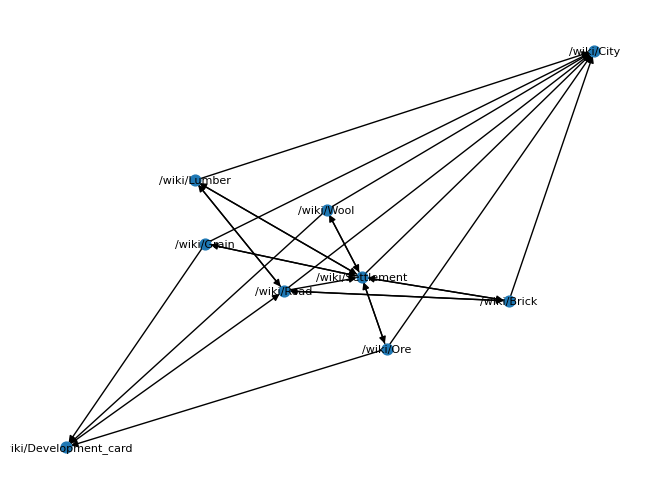

In [14]:
interesting_pages = [
    '/wiki/Lumber', '/wiki/Brick', '/wiki/Wool', '/wiki/Grain', '/wiki/Ore', # Resources
    '/wiki/Road', '/wiki/Settlement', '/wiki/City', '/wiki/Development_card' # Buildings (and "build-able" Development card)
]

G_sub_buildings = G_catan.subgraph(interesting_pages)

display(pd.DataFrame(nx.adjacency_matrix(G_sub_buildings).todense(), index=list(G_sub_buildings.nodes), columns=list(G_sub_buildings.nodes)))

for t in networkx_pagerank(G_sub_buildings):
    print(t)
    
nx.draw(G_sub_buildings, with_labels=True, node_size=60, font_size=8) 

**Answer the questions:**

1. [2p] What is the difference between *City* and *Settlement* in the context of PageRank value determination?
2. [2p] Why do *Lumber* and *Brick* score higher than other resources (*Wool*, *Ore*, *Grain*)?

1. Differences between City and Settlement in the context of PageRank value determination are:

    - Settlement page also goes to City, which gives City one more in-connection;
    - City page has higher amount of in-connections, since every other page somehow leads to City (including Settlement)


2. Lumber and Brick score higher than other resources (Wool, Ore, Grain), because:

    - Wool, Ore, Grain can be used in Road only after passing Development card state. However, Lumber and Brick can be used directly for Road;

    - Wool, Ore, Grain are needed only for Settlement, whereas Lumber and Brick are needed both for Road and Settlement.

### Task 4 - Analysis of the subset of pages about resources and hexes [5p]

<img src="catan_hexes_resources.jpg" alt="drawing" width="500"/>

,/wiki/Hill,/wiki/Hex,/wiki/Pasture,/wiki/Forest,/wiki/Grain,/wiki/Ore,/wiki/Resource_card,/wiki/Brick,/wiki/Lumber,/wiki/Field,/wiki/Mountain,/wiki/Wool
/wiki/Hill,0,0,0,0,0,0,0,1,0,0,0,0
/wiki/Hex,1,0,1,1,0,0,0,0,0,1,1,0
/wiki/Pasture,0,0,0,0,0,0,0,0,0,0,0,0
/wiki/Forest,0,0,0,0,0,0,0,0,1,0,0,0
/wiki/Grain,0,0,0,0,0,0,0,0,0,1,0,0
/wiki/Ore,0,0,0,0,0,0,0,0,0,0,1,0
/wiki/Resource_card,1,0,1,1,1,1,0,1,1,1,1,1
/wiki/Brick,1,0,0,0,0,0,0,0,0,0,0,0
/wiki/Lumber,0,0,0,1,0,0,0,0,0,0,0,0
/wiki/Field,0,0,0,0,1,0,0,0,0,0,0,0


('/wiki/Mountain', 0.11595688112863076)
('/wiki/Hill', 0.11595688112863076)
('/wiki/Forest', 0.11595688112863076)
('/wiki/Field', 0.11595688112863076)
('/wiki/Ore', 0.11460003945855037)
('/wiki/Lumber', 0.11460003945855037)
('/wiki/Grain', 0.11460003945855037)
('/wiki/Brick', 0.11460003945855037)
('/wiki/Pasture', 0.03217820867618207)
('/wiki/Wool', 0.016035529412634076)
('/wiki/Resource_card', 0.014779289781229565)
('/wiki/Hex', 0.014779289781229565)


KeyboardInterrupt: 

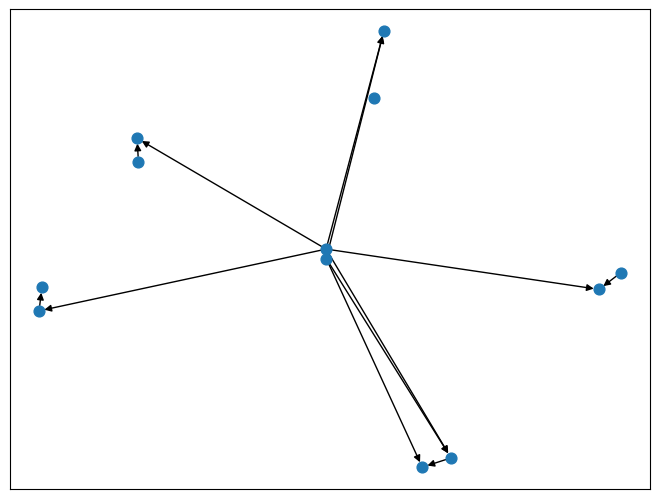

In [15]:
interesting_pages = [
    '/wiki/Hex', '/wiki/Resource_card', # A place from which to get a resource, Resource
    '/wiki/Forest', '/wiki/Lumber', 
    '/wiki/Hill', '/wiki/Brick',
    '/wiki/Pasture', '/wiki/Wool', 
    '/wiki/Field', '/wiki/Grain', 
    '/wiki/Mountain', '/wiki/Ore',
]

G_sub_res = G_catan.subgraph(interesting_pages)

display(pd.DataFrame(nx.adjacency_matrix(G_sub_res).todense(), index=list(G_sub_res.nodes), columns=list(G_sub_res.nodes)))

for t in networkx_pagerank(G_sub_res):
    print(t)

nx.draw(G_sub_res, with_labels=True, node_size=60, font_size=8) 

In [ ]:
interesting_pages = [
    '/wiki/Resource_hex', '/wiki/Resource_card', # A place from which to get a resource, Resource
    '/wiki/Forest', '/wiki/Lumber', 
    '/wiki/Hill', '/wiki/Brick',
    '/wiki/Pasture', '/wiki/Wool', 
    '/wiki/Field', '/wiki/Grain', 
    '/wiki/Mountain', '/wiki/Ore',
]

G_sub_res = G_catan.subgraph(interesting_pages)

display(pd.DataFrame(nx.adjacency_matrix(G_sub_res).todense(), index=list(G_sub_res.nodes), columns=list(G_sub_res.nodes)))

for t in networkx_pagerank(G_sub_res):
    print(t)

nx.draw(G_sub_res, with_labels=True, node_size=60, font_size=8) 

**Answer the questions:**

1. [2p] Why are the PageRank values for the *Pasture-Wool* pair lower than for the rest of the resource pairs (e.g., *Mountain-Ore*)? What changes would make them have comparable PageRank values?
2. [3p] Replace *'/wiki/Hex'* with *'/wiki/Resource_hex'*. Try to explain why PageRank values changed a lot for each group of pages.

1.1 PageRank values for the Pasture-Wool pair lower than for the rest of the resource pairs (e.g., Mountain-Ore), because:

- There's only one-directional connection from Wool to Pasture, in comparison with both-sided connection of the rest Resource pairs (e.g., Grain <-> Field).
    
1.2 Changes that would make them have comparable PageRank values:
       
-  Create connection Pasture -> Wool.

2. PageRank values changed a lot for each group of pages, because:

- Resource_hex goes to every other page, whereas Hex goes only to some of them;

- Hex has no in-connections, whereas there're four of them in Resource_hex.

# Tram stops graph in Poznań

The scripts used for scraping are in the *scraper.ipynb* file.

Connections between the tram stops come from ZTM Poznań webpage: https://www.ztm.poznan.pl/pl/rozklad-jazdy

In [ ]:
with open('tram_stops.pickle', 'rb') as handle:
    d = pickle.load(handle)

G_tram = nx.DiGraph(d)

In [ ]:
print(G_tram.nodes)
nx.draw(G_tram, with_labels=False, node_size=60, font_size=8)

### Task 5 - Test tram stops PageRank with different alpha values [2p]

In [ ]:
for alpha in [0.0, 0.25, 0.5, 0.75, 0.9, 0.99, 1.0]:
    print('ALPHA:', alpha)
    for tram_stop in stochastic_matrix_pagerank(G_tram, alpha)[:5]:
        print(tram_stop)

**Answer the question:**

1. [2p] Try to explain why, depending on $\alpha$, is a different tram stop in the first place?

1. There's a different tram stop in the first place, depending on $\alpha$, because:

- $\alpha$ corresponds to randomness of choice => having $\alpha$ = 0, we get completely random set of stops with the same PageRank, due to "ommiting" $\alpha$ * Mv part of formula, leaving only v_start, which is uniformly distributed;

- The higher $\alpha$ gets => the lesser randomness gets => stops with higher PageRank get first places, since they are the most "driveable" stop.

### Task 6 - Subset of tram stops [6p]

In [ ]:
interesting_stops = [
    'Ogrody', 'Żeromskiego', 'Polna', 'Rynek Jeżycki', 'Kraszewskiego', 'Stare Zoo', 'Most Dworcowy',
    'Bałtyk', 'Rondo Kaponiera', 'Bukowska', 'Matejki', 'Wojskowa', 'Ostroroga', 'Rondo Nowaka-Jeziorańskiego', 
    'Arena', 'Most Teatralny', 'Poznańska', 'Fredry', 'Zamek', 'Dworzec Zachodni', 'Most Dworcowy', 'Poznań Główny',
]

G_sub_tram = G_tram.subgraph(interesting_stops)

display(pd.DataFrame(nx.adjacency_matrix(G_sub_tram).todense(), index=list(G_sub_tram.nodes), columns=list(G_sub_tram.nodes)))

for t in networkx_pagerank(G_sub_tram):
    print(t)

nx.draw(G_sub_tram, with_labels=True, node_size=60, font_size=8) 

**Answer the question:**

1. [2p] Why *Żeromskiego* has a comparable (or even higher) PageRank as *Rondo Kaponiera* even though the latter has more neighbors in the graph?
2. [4p] Suggest a modification of the PageRank algorithm that would take into account the number of lines that pass between adjacent stops. Describe which elements of the algorithm you would modify for this purpose.

1. Żeromskiego has a comparable (or even higher) PageRank as Rondo Kaponiera even though the latter has more neighbors in the graph, because:

- We have to consider not only the number of neighbors, but also the number of neigbors of stops you can get from these neighbors. Meaning that, e.g., such neighbor of Rondo Kaponiera as Most Dworcowy links to four other stops, which gives Rondo Kaponiera lesser score from it, than, e.g., in case of Bukowska of Żeromskiego that is also linked only with Rondo Nowaka-Jeziorańskiego.

2. To make the initial adjacency matrix not binary by defining number of lines that pass between adjacent stops in it, which will futherly increase the probability of getting to this stop.

### Task 7 - TrustRank algorithm implementation [3p]

Use the PageRank implementation from the *stochastic matrix approach*. The only change from PageRank implementation is the assumption, that in the TrustRank, jump to *any* page always ends in one of the trusted pages. It is also necessary to provide a list of trusted nodes. Modify the mathematical formula and the implementation of the algorithm in such way. 

In [ ]:
def trustrank(graph: nx.DiGraph, trusted_nodes: list, alpha: float = 0.85, epsilon: float = 0.0000001) -> list:
    nodes = sorted(list(graph.nodes))
    v_start = np.repeat(0, len(nodes))
    v_start[trusted_nodes] = 1
    v_start = v_start / sum(v_start)
    M = nx.to_numpy_array(graph, nodelist=nodes)
    
    M /= M.sum(axis=1, keepdims=True)
    M = np.nan_to_num(M)
    M = M
    v = v_start.copy()
    v_hat = np.repeat(99999, len(v))

    while True:
        v = (1 - alpha) * v_start + alpha * (M.T @ v)
        if np.all(abs(v - v_hat) < epsilon):
            break
        v_hat = v.copy()
    
    pagerank = {nodes[i]: v[i] for i in range(len(v))}
    pagerank_sorted = sorted(pagerank.items(), key=lambda v:(v[1],v[0]), reverse=True)

    return pagerank_sorted

trustrank(G_random, [0, 2])

In [ ]:
G_trustrank = nx.DiGraph()

G_trustrank.add_nodes_from(range(7))

G_trustrank.add_edge(0, 1)
G_trustrank.add_edge(2, 1)
G_trustrank.add_edge(3, 1)
G_trustrank.add_edge(4, 1)
G_trustrank.add_edge(1, 5)
G_trustrank.add_edge(5, 2)
G_trustrank.add_edge(5, 6)
G_trustrank.add_edge(6, 0)
G_trustrank.add_edge(6, 2)
G_trustrank.add_edge(0, 3)
G_trustrank.add_edge(6, 4)
    
print(G_trustrank.nodes)
print(nx.adjacency_matrix(G_trustrank).todense())
nx.draw(G_trustrank, with_labels=True)

trustrank(G_trustrank, [3, 4])

### Task 8 - TrustRank example [4p]

For the *G_trustrank* graph above, assume that good pages are 3 and 4.

**Answer the questions:**

1. [2p] Why did the good pages (3, 4) get one of the lowest PageRank values in the graph?
2. [2p] How can you fix it?

1. Good pages (3, 4) get one of the lowest PageRank values in the graph, because:

- They have got low number of in and out connections (only one in both cases) and $(\alpha)$ is too large:

    - Number of conncections impacts on Mv part of v equation
    
    - The trust to pages is considered in v_start

- Therefore, (1 - $\alpha$) is small => (1 - $\alpha$) * v_start consideres the trust to pages less and number of conncetions, specified in $\alpha$ * Mv more.
 

2. Decrease value of $\alpha$.

### Task 9 - HITS algorithm implementation [5p]

Implement HITS algorithm. You can choose whether to use the iterative version or using the eigenvector. Return the results in the form of two lists of tuples (similar to PageRank and TrustRank, but in two separate lists - authorities and hubs). In case of iterative approach, normalize the vector after each iteration (sum up to 1).

**Hint** - update the values of both vectors *simultaneously*. Use the *hubs* and *authorities* values from the previous iteration to update both vectors. Don't use updated *hubs* vector to update *authorities* during the same iteration and vice versa.

In [ ]:
def hits(graph: nx.DiGraph, epsilon: float = 0.0000001) -> list:
    nodes = sorted(list(graph.nodes))
    L = nx.to_numpy_array(graph, nodelist=nodes)
    LLT = L @ L.T
    LTL = L.T @ L
    h = np.repeat(1 / len(nodes), len(nodes))
    a = np.repeat(1 / len(nodes), len(nodes))

    for _ in range(10000):
        h = h @ LLT
        a = a @ LTL
        
        h = h / sum(h)
        a = a / sum(a)
    
    hubs = {nodes[i]: h[i] for i in range(len(h))}
    aths = {nodes[i]: a[i] for i in range(len(a))}
    sorted_hubs = sorted(hubs.items(), key=lambda v:(v[1],v[0]), reverse=True)
    sorted_aths = sorted(aths.items(), key=lambda v:(v[1],v[0]), reverse=True)
    
    return sorted_hubs, sorted_aths

hits(G_deathend)

### Task 10 - HITS analysis [5p]

In [ ]:
interesting_pages = [
    '/wiki/Hex', '/wiki/Resource_card', # A place from which to get a resource, Resource
    '/wiki/Forest', '/wiki/Lumber', 
    '/wiki/Hill', '/wiki/Brick',
    '/wiki/Pasture', '/wiki/Wool', 
    '/wiki/Field', '/wiki/Grain', 
    '/wiki/Mountain', '/wiki/Ore',
]

G_sub_res = G_catan.subgraph(interesting_pages)

nx.draw(G_sub_res, with_labels=True, node_size=60, font_size=8)

In [ ]:
hits(G_sub_res)

**Answer the question:**

1. [2p] Check the HITS values in the graph above, then change *Hex* to *Resource_hex* again. How has this affected the results and why?

1. Changes in results:

- Hex has 0 authority, meaning it got no in-connections, whereas there appear some of them in case of Resource_hex, making its authority score higher;

- There're replacements in ranking, since there appeared both-sided conncetions of Resource_hex, increasing hubs and authority scores of these pages.

In [ ]:
nx.draw(G_sub_tram, with_labels=True, node_size=60, font_size=8) 

In [ ]:
print(nx.adjacency_matrix(G_sub_tram).todense())
hits(G_sub_tram)

**Answer the question:**

2. [3p] Why are the results for Authorities and Hubs very similar?

2. The results for Authorities and Hubs very similar, because:

- Most of the connections are both-sided, meaning that they are both hubs and authorities in such cases.